In [38]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import OrderedDict
import scipy.io as sio

# Preprocessing

In [2]:
## DEFINE INPUT PARAMETERS
# defining velocity, density, and viscocity for fluid
u0 = 1 # lid velocity
rho0 = 1
nu0 = 0.01
N = 4400 # number of collocation data points [x,y]

In [150]:
def Uniform_with_Cylinder(u0, N_col=50000, N_circ=400, r=0.5):
    """
    Create collocation points inside a 1by1 box with a cylinder in the middle

    Args:
        u0 : Inlet velocity
        N_col : number of collocation points # note the acc number is slightly less as we are removing points in the cylinder
        N_circ : Number of points along cylinder boundary
        r : Cylinder radius 
    
    Returns: 
        Tensors of:
        X_col : Collocation points [x, y]
        BC_X : Boundary points [x, y]
        BC_Y : Boundary condition values [u, v]
    """

    # setting up domain size
    xc, yc = 0, 0  # cylinder center

    # CREATING collocation points
    # set random points across the domain using the random normal distribution function hence *3 or *10 to change standard dev and get distribution centred round cylinder
    y = 2*np.random.randn(N_col,1)
    x = 4*np.random.randn(N_col,1)
    
    xy = np.hstack((x, y))  
    

    # Distance from cylinder center
    dist = np.sqrt((xy[:, 0] - xc)**2 + (xy[:, 1] - yc)**2)

    # Keep only points outside the cylinder. Boolean mask for cylinder and BCs
    valid_col = (dist > r) & (xy[:,0]>-10) & (xy[:,1]>-7) & (xy[:,1]< 7)
    xy_outside = xy[valid_col]

    X_col = torch.tensor(xy_outside, dtype=torch.float32)

    # CREATING Boundary condition locations
    # domain currently set y = -7 to 7 : x = -10 to 25

    # evenly distribute BC points along the sides
    N_BC = int(np.sqrt(N_col) // 2)
    y = np.linspace(-7, 7, N_BC)
    x = np.linspace(-10, 35, N_BC)

    # turn those points into x,y co-ords
    b_left   = np.column_stack([(np.ones_like(y)*-10), y])
    b_right  = np.column_stack([np.ones_like(y)*35, y])
    b_bottom = np.column_stack([x, np.ones_like(x)*-7])
    b_top    = np.column_stack([x, np.ones_like(x)*7])

    # cylinder BCs
    theta = np.linspace(0, 2*np.pi, N_circ)
    cylinder_x = (r * np.cos(theta) + xc)
    cylinder_y = (r * np.sin(theta) + yc)
    cylinder_xy = np.column_stack([cylinder_x, cylinder_y])

    # Add all BC points
    BC_X_np = np.vstack([b_left, b_bottom, b_right, b_top, cylinder_xy])
    BC_X = torch.tensor(BC_X_np, dtype=torch.float32)

    # CREATING the BC_Y essentially 0s everywhere except inlet
    # tensor of zeros for all walls except inlet
    walls_Y = torch.zeros_like(torch.tensor(np.vstack([b_top, b_bottom, b_right]), dtype=torch.float32))

    # inlet velocity
    inlet = torch.zeros_like(torch.tensor(b_left, dtype=torch.float32))
    inlet[:, 0] = u0

    # Cylinder no slip so 0
    cylinder_uv = torch.zeros_like(torch.tensor(cylinder_xy, dtype=torch.float32))

    # Combine boundary velocities
    BC_Y = torch.cat([inlet, walls_Y,  cylinder_uv], dim=0)

    return X_col, BC_X, BC_Y

def Data():
    """
    loads data from benchmark file

    Args:
        
    Returns: As Tensors (dim = Nx2)
        X_D   : coordinates of data points [x,y] for u,v, dim = [N*2]
        U_D   : training output [u*, v*] at data points X_D, dim = [N*2] 
        PXY_D : coordinates of data points [x,y] for p, dim = [N*2]
        P_D   : training output [p*] at data points PXY_D
    Notes about data:
        - flow around a cylinder
        - Re = 100 , all data has been non-dimensionalised?? , inlet velocity u = 1
    """

    ## Read file holding training data
    xy_data = sio.loadmat("Cyl100_Sean/xstar.mat")
    uv_data = sio.loadmat("Cyl100_Sean/ustar_Aug24.mat") 
    # pressure is calculated at different data points
    p_data  = sio.loadmat("Cyl100_Sean/pstar.mat")
    pxy_data  = sio.loadmat("Cyl100_Sean/xpstar.mat")

    uv_data_np = np.array(uv_data["ustar"][:,:,0])
    u_np = uv_data_np[:,0]
    v_np = uv_data_np[:,1]
    
    xy_data_np = np.array(xy_data["xstar"])
    x_np = xy_data_np[:,0]
    y_np = xy_data_np[:,1]

    p_data_np = np.array(p_data["pstar"])
    pxy_data_np = np.array(pxy_data["xpstar"])
    
    x = torch.tensor(x_np, dtype=torch.float32)
    y = torch.tensor(y_np, dtype=torch.float32)
    u = torch.tensor(u_np, dtype=torch.float32)
    v = torch.tensor(v_np, dtype=torch.float32)
    

    X_D = torch.column_stack((x, y))
    U_D = torch.column_stack((u,v))
    PXY_D = torch.tensor(pxy_data_np, dtype=torch.float32)
    P_D   = torch.tensor(p_data_np[:,0:1], dtype=torch.float32)

    #print(X_D.size(), U_D.size(),PXY_D.shape(), P_D.shape())
    #print(PXY_D.size(), P_D.size())
    return X_D, U_D, PXY_D, P_D

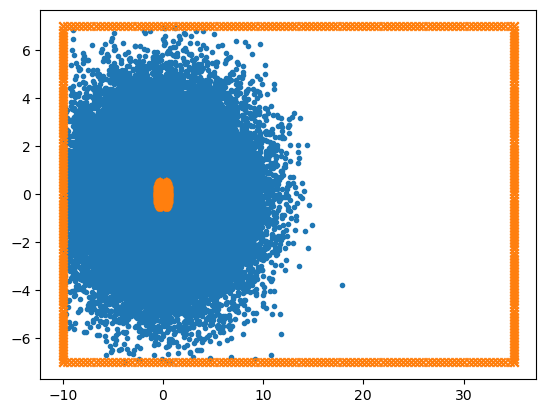

In [151]:
X_col, BC_X, BC_Y= Uniform_with_Cylinder(1)
Data()
plt.scatter(X_col[:,0].numpy(),X_col[:,1].numpy(),marker='.')
plt.scatter(BC_X[:,0].numpy(),BC_X[:,1].numpy(),marker='x')
#plt.xlim(-2,5)
#plt.ylim(-2,2)

In [97]:
## Compute gradients
def grad(outputs, inputs):
    return torch.autograd.grad(
        outputs, inputs,
        grad_outputs=torch.ones_like(outputs),
        create_graph=True,
        retain_graph=True
    )[0]
def compute_gradients(model, xy):
    """
    Args:
        model : PyTorch neural network, with three models inside it (u,v and p) for input xy
        xy    : tensor of shape (N, 2), # when setting up model set requires_grad=True

    Returns:
        p_grads : (p, p_x, p_y) as a tuple
        u_grads : (u, u_x, u_y, u_xx, u_yy) as a tuple
        v_grads : (v, v_x, v_y, v_xx, v_yy) as a tuple
    """
    # create a clone so we dont change the original tensor
    # detatch the xy data from previous gradients so it can be evaluated in isolation
    xy = xy.clone().detach().requires_grad_(True)  
    x = xy[:, 0:1]
    y = xy[:, 1:2]

    # Make a fwd pass that goes through the combined mini models collecting all coefficients needed for derivatives
    u_v_p = model(torch.cat([x, y], dim=1))
    u = u_v_p[:,0:1]
    v = u_v_p[:,1:2]
    p = u_v_p[:,2:3]

    
    # First-order derivatives
    p_x = grad(p, x)
    p_y = grad(p, y)

    # Second-order derivatives
    u_x = grad(u, x)
    u_y = grad(u, y)
    v_x = grad(v, x)
    v_y = grad(v, y)

    # Third-order derivatives
    u_xx = grad(u_x, x)
    u_yy = grad(u_y, y)
    v_xx = grad(v_x, x)
    v_yy = grad(v_y, y)
    
    p_grads = (p, p_x, p_y)
    u_grads = (u, u_x, u_y, u_xx, u_yy)
    v_grads = (v, v_x, v_y, v_xx, v_yy)

    return p_grads, u_grads, v_grads

# Model Creation

In [98]:
## LOSS EQUATIONS
def navier_stokes_loss(model,X):
    """
    calculates steady navier stokes residuals at collocation points

    Args: 
        model : whatever model calls this function
        X : input collocation [x,y] coords as defined in models data creation

    Returns: 
        tensor of all collocation point residuals
    """
    p_grads, u_grads, v_grads = compute_gradients(model, X)
    _, p_x, p_y = p_grads
    u, u_x, u_y, u_xx, u_yy = u_grads
    v, v_x, v_y, v_xx, v_yy = v_grads

    #compute PDE residuals
    u_eqn = u*u_x + v*u_y + p_x/rho0 - nu0*(u_xx + u_yy)
    v_eqn = u*v_x + v*v_y + p_y/rho0 - nu0*(v_xx + v_yy)
    

    # combine into one tensor
    # [u_residual, v_residual, continuity]
    return torch.cat([u_eqn, v_eqn,(u_x+v_y)], dim=1)
    
def BC_loss(model,BC_X):
    """
    calculates u and v at boundary conditions

    Args: 
        model : whatever model calls this function
        BC_X : Input Boundary conditions [x,y] coords as defined in models data creation
        
    Returns: 
        tensor of u,v at all boundary condition coords
    """
    _, u_grads, v_grads = compute_gradients(model,BC_X)
    u, u_x, u_y, u_xx, u_yy = u_grads
    v, v_x, v_y, v_xx, v_yy = v_grads
    return torch.cat([u, v], dim=1)
def UV_Data_loss(model, X_D):
    p_grads, u_grads, v_grads = compute_gradients(model,X_D)
    p, p_x, p_y = p_grads
    u, u_x, u_y, u_xx, u_yy = u_grads
    v, v_x, v_y, v_xx, v_yy = v_grads
    
    return torch.cat([u, v], dim=1)
def P_Data_loss(model, PXY_D):
    p_grads, u_grads, v_grads = compute_gradients(model,PXY_D)
    p, p_x, p_y = p_grads
    u, u_x, u_y, u_xx, u_yy = u_grads
    v, v_x, v_y, v_xx, v_yy = v_grads

    # solution need to use torch.cat rather then torch.tensor to create p data loss as it retains the gradient computation graph whilst torch.tensor performs a .detach()
    pval = torch.cat([p], dim=1)
    
    return pval

## Define sub models and combine into 1 model

In [99]:
## CREATING THE MINI MODEL FOR u,v AND p AND THEN COMBINE THEM INTO ONE MODEL

# sub model for u,v and p 
class submodel(nn.Module):
    def __init__(
            self,
            N_input,
            N_hidden_arr,
            N_output,
            activation = nn.Tanh
    ):
        super(submodel, self).__init__()  # Create network

        # Create input layer w/ activation function
        layers = [('Input', nn.Linear(N_input, N_hidden_arr[0]))]
        layers.append(('Input activation', activation()))

        # Create hidden layers
        for i in range(len(N_hidden_arr)-1):
            layers.append(
                ("Hidden %d" % (i+1), nn.Linear(N_hidden_arr[i], N_hidden_arr[i+1]))
            )
            layers.append(('Hidden activation %d' % (i+1), activation()))
        layers.append(('Output', nn.Linear(N_hidden_arr[-1], N_output)))
        layerdict = OrderedDict(layers)
        self.layers = nn.Sequential(layerdict)

    def forward(self, x):
        y = self.layers(x)
        return y


class Net(nn.Module):
    def __init__(self, N_input, N_hidden_arr, N_output, activation = nn.Tanh):
        
        super(Net, self).__init__()  # Create network
        # creates three models using submodel as the blueprint
        self.model_u = submodel(N_input, N_hidden_arr ,N_output, activation)
        self.model_v = submodel(N_input, N_hidden_arr, N_output, activation)
        self.model_p = submodel(N_input, N_hidden_arr, N_output, activation)


    # combine the outputs of all the models into a single output
    def forward(self, xy):
        out_u = self.model_u(xy)
        out_v = self.model_v(xy)
        out_p = self.model_p(xy)
        combined = torch.cat((out_u, out_v, out_p), dim=1)
        return combined


        

## Defining the model

In [105]:
## create neural network

class PINN:
    def __init__(self):
        ### Need to change this to check if gpu available as well
        device = torch.device("cpu")
        print("Using CPU")
        self.model = Net(
            N_input=2,
            N_hidden_arr=[32,16,16,32],
            N_output = 1
        ).to(device)
    
        # DATA CREATION 
        self.X, self.BC_X, self.BC_Y =  Uniform_with_Cylinder(u0)
        self.X_D, self.U_D, self.PXY_D, self.P_D = Data()

        # copy and seperate tensors into format for loss calculations
        self.X    = self.X.clone().detach().requires_grad_(True)
        self.BC_X = self.BC_X.clone().detach().requires_grad_(True)

        self.X_D   = self.X_D.clone().detach().requires_grad_(True)
        self.PXY_D = self.PXY_D.clone().detach().requires_grad_(True)
        
        # OPTIMISERS
        self.optimiser = torch.optim.LBFGS(
            params=self.model.parameters(),
            lr=1.0,
            max_iter = 75*10**3,
            max_eval = 75*10**3,
            history_size=50,
            tolerance_change=1e-7,
            tolerance_grad=1e-7,
            line_search_fn="strong_wolfe"
        )
        self.adam = torch.optim.Adam(self.model.parameters())

        
        self.loss_fn = nn.MSELoss()

        # Counter for printing loss
        self.iter =1
        
    # Loss
    def compute_loss(self):
        # Compute PDE residuals at collocation points
        residuals = navier_stokes_loss(self.model, self.X)
        ru, rv, conservation  = residuals[:, 0:1], residuals[:, 1:2], residuals[:, 2:3]

        # PDE loss (residuals against tensor of zeros)
        pde_loss = self.loss_fn(ru, torch.zeros_like(ru)) + self.loss_fn(rv, torch.zeros_like(rv))+self.loss_fn(conservation, torch.zeros_like(conservation))

        # BC loss
        bc_loss = BC_loss(self.model,self.BC_X)
        bc_loss = self.loss_fn(bc_loss,self.BC_Y)

        # Data Loss
        uv_data_loss = UV_Data_loss(self.model, self.X_D)
        uv_data_loss = self.loss_fn(uv_data_loss, self.U_D)
        
        p_data_loss  = P_Data_loss(self.model, self.PXY_D)
        p_data_loss = self.loss_fn(p_data_loss, self.P_D)

        data_loss = p_data_loss+uv_data_loss

        if self.iter <= 500:
            total_loss = data_loss
        elif self.iter > 500:
            total_loss = pde_loss + bc_loss +data_loss
        # print the loss
        if self.iter % 100 == 0:
            print(f"Iteration {self.iter:5}, Total Loss {total_loss:.9f}, Data loss {data_loss:.9f} = uv data loss: {uv_data_loss} + p data loss: {p_data_loss} ,pde loss {pde_loss:.9f}, BC loss {bc_loss:.9f}")
            
        self.iter+= 1
        
        return total_loss
    
    def train(self, adam_epochs=300, lbfgs_epochs=10):
        self.model.train()

        for epoch in range(adam_epochs):
            self.adam.zero_grad()
            loss = self.compute_loss()
            loss.backward()
            self.adam.step()

            # extra printing of loss for when adam optimiser in use
            if epoch % 50 == 0:
                with torch.inference_mode():  
                    print(f"[Adam] Step {epoch:4}, Loss = {loss.item():.6e}")
        
        for epoch in range(lbfgs_epochs):
            def closure():
                self.optimiser.zero_grad()
                loss = self.compute_loss()
                loss.backward()
                return loss

            self.optimiser.step(closure)
            
    def eval(self):
        self.model.eval()

In [106]:
test = PINN()
#print(test)

Using CPU


In [107]:
test.train()

[Adam] Step    0, Loss = 5.323519e-01
[Adam] Step   50, Loss = 5.174376e-02
Iteration   100, Total Loss 0.043784540, Data loss 0.043784540 = uv data loss: 0.04252943769097328 + p data loss: 0.0012551030376926064 ,pde loss 0.002857223, BC loss 0.407941669
[Adam] Step  100, Loss = 4.369256e-02
[Adam] Step  150, Loss = 3.921257e-02
Iteration   200, Total Loss 0.035003856, Data loss 0.035003856 = uv data loss: 0.033859528601169586 + p data loss: 0.0011443282710388303 ,pde loss 0.004175111, BC loss 0.390727729
[Adam] Step  200, Loss = 3.493423e-02
[Adam] Step  250, Loss = 3.181600e-02
Iteration   300, Total Loss 0.029017163, Data loss 0.029017163 = uv data loss: 0.02791612781584263 + p data loss: 0.0011010351590812206 ,pde loss 0.008012174, BC loss 0.334290355
Iteration   400, Total Loss 0.021949125, Data loss 0.021949125 = uv data loss: 0.02092437446117401 + p data loss: 0.0010247514583170414 ,pde loss 0.040707886, BC loss 0.276147723
Iteration   500, Total Loss 0.015751038, Data loss 0.01

KeyboardInterrupt: 

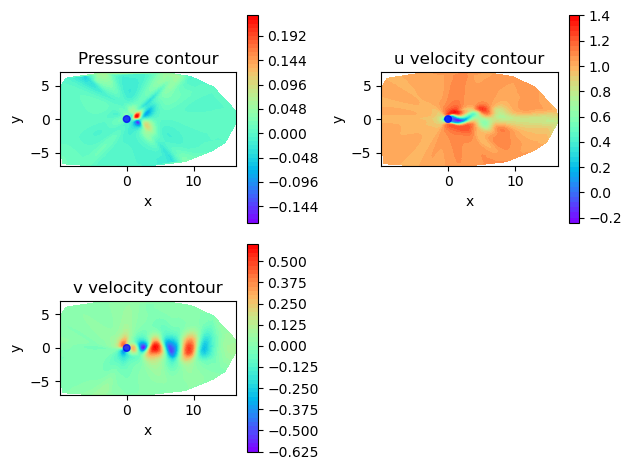

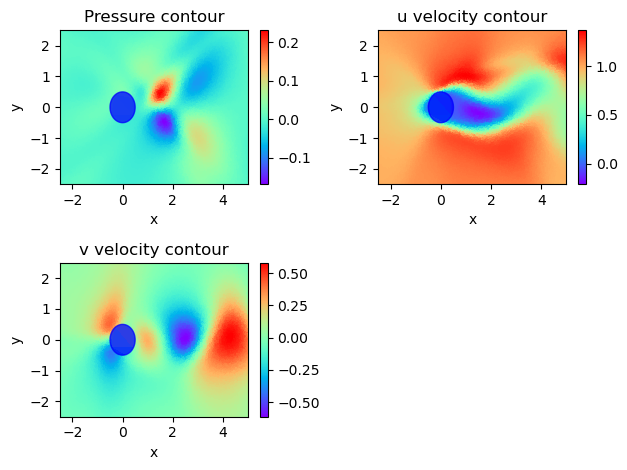

In [152]:
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Circle

X, BC_X, BC_Y = Uniform_with_Cylinder(u0)
    
X = X.clone().detach().requires_grad_(True)      


# forward pass of the model !!! fwd pass outside eval/inference is okay as long as you dont .backward()
# we have to call .model() because our model is nested inside class PINN
y_preds = test.model(X)
u = y_preds[:, 0:1]   # u velocity
v = y_preds[:, 1:2]
p = y_preds[:, 2:3]     #pressure


# convert to array for postprocessing
p_np   = p.detach().numpy()
u_np   = u.detach().numpy()
v_np   = v.detach().numpy()
x_np   = X[:, 0:1].detach().numpy()
y_np   = X[:, 1:2].detach().numpy()

# create data points to plot a circle on the plots
xc,yc, r = 0,0,0.5
theta = np.linspace(0, 2*np.pi, 400)
cylinder_x = (r * np.cos(theta) + xc)
cylinder_y = (r * np.sin(theta) + yc)


def tricontour(gs, x, y, z, title):
    """
    this is an explanation for tripcontour() and tripplot() which are two different methods for plotting contour type plots

    Args:
        grid: plot position in subplot
        x: x-array (x coords)
        y: y-array  (y coords)
        z: z-array (engineering value at [x,y])
        title: title 
    """
    plt.subplot(gs)
    tcf = plt.tricontourf(x, y, z, levels=50, cmap='rainbow')
    # Add the circle
    plt.fill(cylinder_x,cylinder_y, color='blue', alpha=0.75)
    plt.colorbar(tcf)
    plt.gca().set_aspect('equal')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    

# note we have to squeeze the arrays as they are in column vector format(ML format)
gs = GridSpec(2,2)
tricontour(gs[0,0], np.squeeze(x_np), np.squeeze(y_np), np.squeeze(p_np), 'Pressure contour')
tricontour(gs[0,1], np.squeeze(x_np), np.squeeze(y_np), np.squeeze(u_np), 'u velocity contour')
tricontour(gs[1,0], np.squeeze(x_np), np.squeeze(y_np), np.squeeze(v_np), 'v velocity contour')
plt.tight_layout()
plt.show()


def tripplot(gs, x, y, z, title):
    plt.subplot(gs)
    plt.tripcolor(x, y, z, cmap='rainbow')
    
    # Add the circle
    plt.fill(cylinder_x,cylinder_y, color='blue', alpha=0.75)
    
    plt.ylim(-2.5,2.5)
    plt.xlim(-2.5,5)
    plt.colorbar()
    
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')

gs2 = GridSpec(2,2)
tripplot(gs2[0,0], np.squeeze(x_np), np.squeeze(y_np), np.squeeze(p_np), 'Pressure contour')
tripplot(gs2[0,1], np.squeeze(x_np), np.squeeze(y_np), np.squeeze(u_np), 'u velocity contour')
tripplot(gs2[1,0], np.squeeze(x_np), np.squeeze(y_np), np.squeeze(v_np), 'v velocity contour')
plt.tight_layout()
plt.show()
